# Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setting up File locations and Checking sample images

In [ ]:
# setting the path and the labels list for classification of targets on the basis in human understandable form

train_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/AV2/Garbage classification')

labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [ ]:
# checking the size of data available to us for training out model

for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "cardboard":	 100
Images of label "glass":	 100
Images of label "metal":	 100
Images of label "paper":	 100
Images of label "plastic":	 100


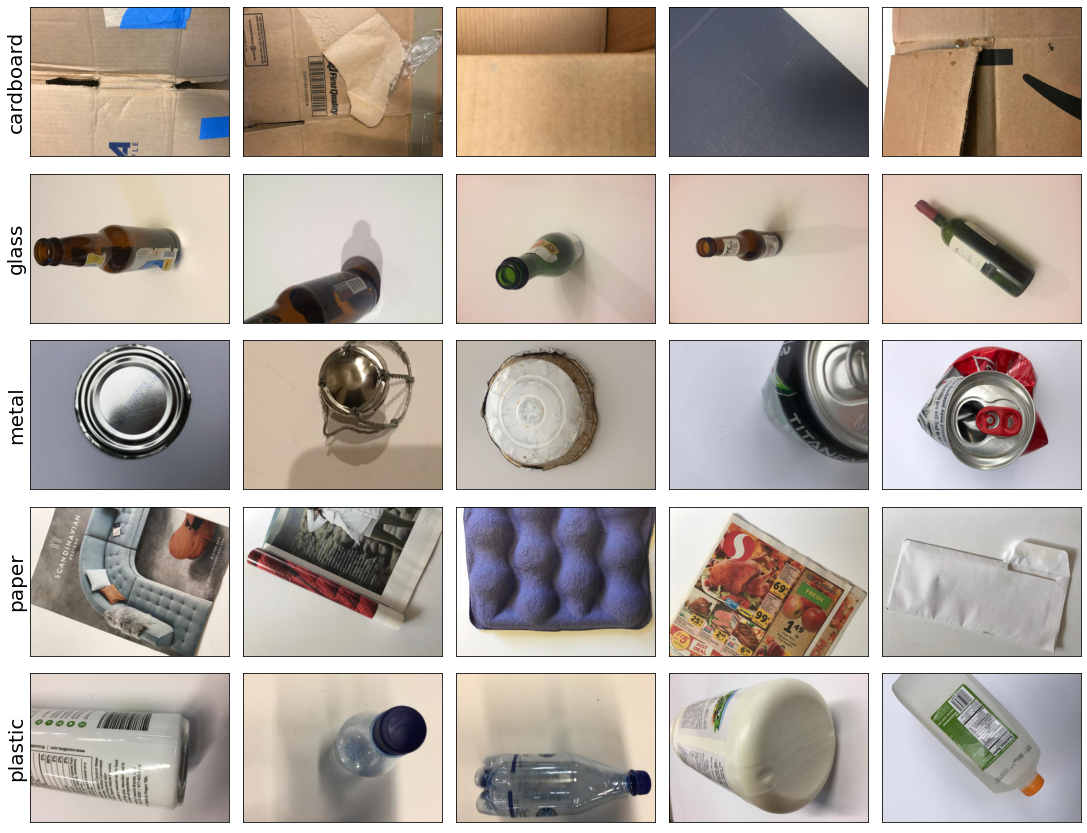

In [ ]:
# plotting images of different review for understanding the dataset

plt.figure(figsize=(30,14))

for i in range(5):
    directory = os.path.join(train_dir, labels[i])
    for j in range(5):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [ ]:
# checking size of individual image

directory = os.path.join(train_dir, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

# Deep Learning

In [ ]:
# creating the model

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 512, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 382, 510, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 380, 508, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 380, 508, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 190, 254, 32)     0         
 )                                                               
                                                        

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr = 0.0001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#creating generators for combining data and increasing the gainable insights by slightly modifying the images in the dataset
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255., 
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory(train_dir, target_size=(384, 512), batch_size=32, class_mode='binary', subset='validation')


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic'}


In [ ]:
# creating the callback function so that it can be used to end the training in case reached a good accuracy rate (above 90%)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(train_generator, epochs=2, verbose=1, validation_data=validation_generator, callbacks=[callbacks])

Epoch 1/2


In [ ]:
test_loss, test_acc = model.evaluate(train_generator,  validation_generator, verbose=2)

print('\nTest accuracy:', test_acc)